In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

from xgboost.sklearn import XGBRegressor
from sklearn import cross_validation, metrics  
from sklearn.metrics import mean_squared_error as mse
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;


<IPython.core.display.Javascript object>

In [3]:
# бесит проверять, посчиталось ли уже
from IPython.display import Audio

play = lambda : Audio("beep-09.mp3", autoplay=True)

In [4]:
train = pd.read_csv('train_preprocessed.csv').drop('Unnamed: 0', 1)
test = pd.read_csv('test_preprocessed.csv').drop('Unnamed: 0', 1)
weights_train = pd.read_csv('train_weights.csv').drop('Unnamed: 0', 1)
y_train = pd.read_csv('y_train.csv').drop('Unnamed: 0', 1)

In [5]:
train.shape, test.shape, weights_train.shape, y_train.shape

((250000, 46), (550000, 46), (250000, 1), (250000, 1))

In [6]:
from scipy.stats import pearsonr
pearsonr(weights_train, y_train)

(array([-0.63098172]), array([ 0.]))

## Сначала для теста предскажем Weight, обучившись на Weight из X, после уже будем предсказывать Label. Почему?
### 1) получится своеобразный стекинг 2 алгоритмов (лин и лог регрессий), что уже хорошо, так как веса и лейбелы слабо коррелируют
### 2) будем использовать информацию о весах

'

Для начала затюним градиентный бустинг для весов

In [7]:
# смотрит на importances и тюнит количество деревьев через 5 cv 
def modelfit(alg, 
             train_,
             target_,
             useTrainCV=True, 
             cv_folds=5, 
             esr=10):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(train_.values, 
                              label=target_.values)
        cvresult = xgb.cv(xgb_param, 
                          xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          early_stopping_rounds=esr, 
                          show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    (train_cv, 
     test_cv, 
     target_train_cv, 
     target_test_cv) = train_test_split( train_,
                                         target_,
                                         test_size=0.3, 
                                         random_state=1337 )

    alg.fit(train_cv, 
            target_train_cv,
            eval_metric='rmse')
        
    predictions = alg.predict(test_cv)
        
    print "RMSE : %.4g" % np.sqrt(mse(target_test_cv.values, predictions))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

Will train until cv error hasn't decreased in 10 rounds.
Stopping. Best iteration: 336


RMSE : 1.141


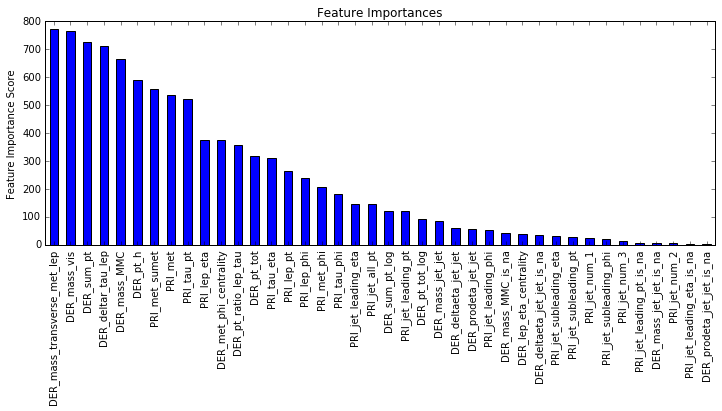

In [8]:
xgb1 = XGBRegressor(
    learning_rate=0.1,
    n_estimators=500,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:linear',
    nthread=-1,
    scale_pos_weight=1,
    seed=1337)

modelfit(xgb1, train, weights_train)

In [9]:
play()

### проверим, не наворотили ли какой-нибудь ерунды в preprocessing


In [10]:
train_raw = pd.read_csv('./training.csv').drop('EventId', 1)
weights_train_raw = train_raw['Weight']
del train_raw['Weight'], train_raw['Label']

Will train until cv error hasn't decreased in 10 rounds.
Stopping. Best iteration: 333


RMSE : 1.139


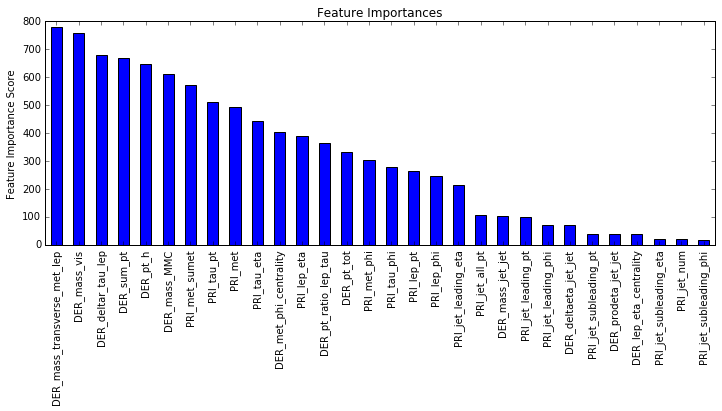

In [11]:
xgb1 = XGBRegressor(
    learning_rate=0.1,
    n_estimators=500,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:linear',
    nthread=-1,
    scale_pos_weight=1,
    seed=1337)

modelfit(xgb1, train_raw, weights_train_raw)

In [12]:
play()

### Ну по крайней мере ничего не испортили =)

In [ ]:
param_test1 = {
 'max_depth':range(3,6,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(
    estimator = XGBRegressor( 
        learning_rate=0.1, 
        n_estimators=336, 
        max_depth=5,
        min_child_weight=1, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective='reg:linear', 
        nthread=-1, 
        scale_pos_weight=1, 
        seed=1337), 
    param_grid=param_test1, 
    scoring='mean_squared_error',
    n_jobs=-1,
    iid=False,
    cv=5)

gsearch1.fit(train, weights_train)
print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
modelfit(gsearch1.best_estimator_, train, weights_train)

In [ ]:
play()

In [ ]:
# play()

In [ ]:
# params = {} 
# params['objective']           = "reg:linear"
# params['eval_metric']         = "rmse"
# params['eta']                 = 0.01
# params['subsample']           = 0.681
# params['colsample_bytree']    = 0.95
# params['seed']                = 1337
# params['njobs']               = -1

# old_cols = train.columns

# train.columns = [str(i) for i in range(0, len(train.columns))]
# test.columns = [str(i) for i in range(0, len(test.columns))]

# from sklearn.cross_validation import train_test_split as tts

# (train_cv, 
#  test_cv, 
#  y_train_cv, 
#  y_test_cv) = tts( train, y_train, 
#                    test_size=0.3, 
#                    random_state=42)
# #                    stratify=y_train )

# import xgboost as xgb

# dtrain = xgb.DMatrix(train_cv, label=y_train_cv)
# dval = xgb.DMatrix(test_cv, label=y_test_cv)
# watchlist = [(dval,'eval')]

# num_trees = 888
# esr = 10

# gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, 
#                 verbose_eval=False, early_stopping_rounds = esr)

# param_grid = {'max_depth': range(5, 7),
#               'objective':['reg:linear'],
#               'n_estimators': range(100, 500),
#               'learning_rate': np.arange(0.01, 0.3, .001), #eta
#               'subsample': np.arange(0.5, 1, .01),
#               'colsample_bytree': np.arange(0.5, 1, .01),
#              }

# from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

# xgb_model = xgb.XGBRegressor()
# n_iter_search=1
# random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid,
#                                    n_iter=n_iter_search, scoring="mean_squared_error",
#                                    n_jobs=8, verbose=10)

# random_search.fit(train, weights_train) 

# xgb.XGBRegressor().get_params().keys()

# print random_search.grid_scores_
# print random_search.best_estimator_
# print random_search.best_score_
# print random_search.best_params_

# # import xgboost as xgb

# # gbm = xgb.XGBRegressor()
# # gbm_params = {
# #     'learning_rate': [0.005, 0.2],
# #     'n_estimators': [100, 1000],
# #     'max_depth': [2, 3, 10],
# # }
# # cv = StratifiedKFold(train_y)
# # grid = GridSearchCV(gbm, gbm_params,scoring='roc_auc',cv=cv,verbose=10,n_jobs=-1)
# # grid.fit(train_X, train_y)

# # print (grid.best_params_)